In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from TreeUtils.graph import BiGraph
from TreeUtils.core.score_handler import ScoreHandler
from TreeUtils.utils import dict_utils
import pydotplus
import numpy as np
import pandas as pd
import lightgbm as lgb
from IPython.display import HTML, Image

In [2]:
# Generating Data for classification problem
n = 50000
p = 100
X, y = make_classification(n_samples=n, n_features=p, n_informative=int(p/2), n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=4, random_state=55)
feature_name = [f'X{i}' for i in range(X.shape[1])]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# fitiing sklearn decision tree classifier
clf = DecisionTreeClassifier(min_samples_split=2000, max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

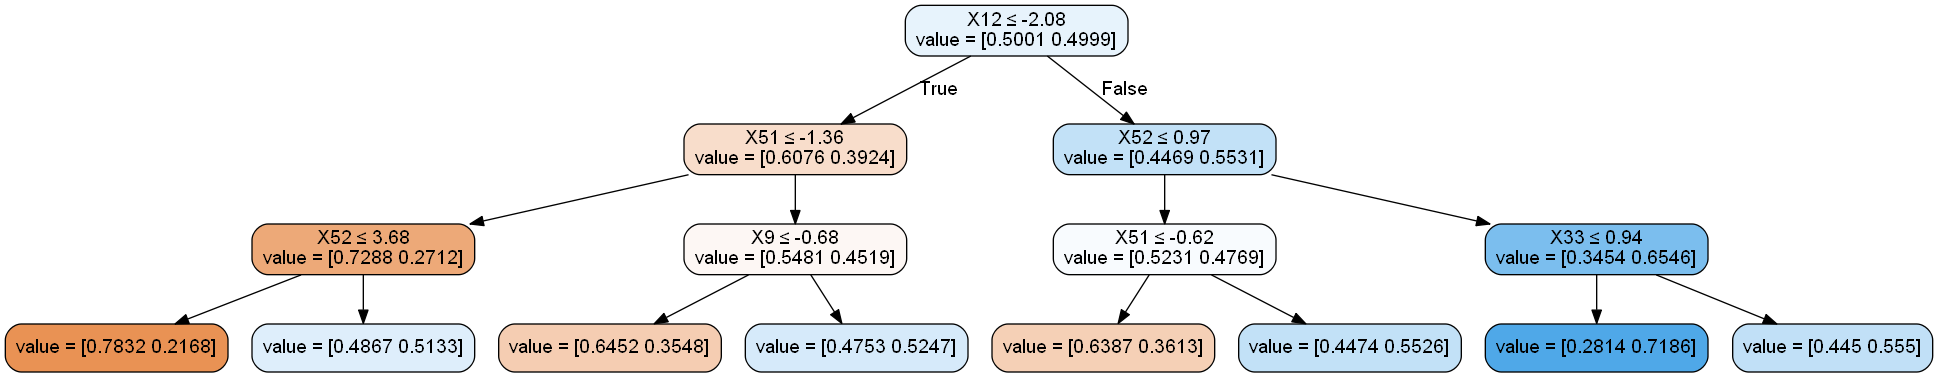

In [3]:
# creating graph from sklearn classifier
graph = BiGraph.from_sklearn_tree(clf)
Image(graph.create_png(features_name=feature_name))

In [4]:
graph.get_graph_info()

{'_fitted': True,
 '_internally_fitted': False,
 'objective': 'classification',
 'n_class': 2,
 'class_name': array([0, 1]),
 'features_name': None,
 'score_data': {'pred_score_key': 'value', 'color_score_key': 'value'},
 'n_features': 100}

In [5]:
HTML(graph.df.to_html())

,depth,parent,child_left,child_right,type,data,score
0,0,0,1,2,0,"{'feature_data': {'split_feature': 12, 'split_criteria': '<=', 'split_threshold': -2.0825871229171753}}","{'gini': 0.4999999943111111, 'sample': 37500, 'value': [0.5000533333333333, 0.49994666666666665]}"
1,1,0,3,4,-1,"{'feature_data': {'split_feature': 51, 'split_criteria': '<=', 'split_threshold': -1.3576117753982544}}","{'gini': 0.4768391903696647, 'sample': 12401, 'value': [0.6076122893315056, 0.3923877106684945]}"
2,1,0,9,10,1,"{'feature_data': {'split_feature': 52, 'split_criteria': '<=', 'split_threshold': 0.9673941433429718}}","{'gini': 0.4943629538037777, 'sample': 25099, 'value': [0.4469102354675485, 0.5530897645324515]}"
3,2,1,5,6,-1,"{'feature_data': {'split_feature': 52, 'split_criteria': '<=', 'split_threshold': 3.68274986743927}}","{'gini': 0.3953342751715758, 'sample': 4085, 'value': [0.7287637698898409, 0.2712362301101591]}"
4,2,1,7,8,1,"{'feature_data': {'split_feature': 9, 'split_criteria': '<=', 'split_threshold': -0.6838884949684143}}","{'gini': 0.4953727707455461, 'sample': 8316, 'value': [0.5481000481000481, 0.4518999518999519]}"
5,3,3,-1,-1,-1,{'feature_data': None},"{'gini': 0.3395860090944033, 'sample': 3335, 'value': [0.783208395802099, 0.21679160419790106]}"
6,3,3,-1,-1,1,{'feature_data': None},"{'gini': 0.49964444444444445, 'sample': 750, 'value': [0.4866666666666667, 0.5133333333333333]}"
7,3,4,-1,-1,-1,{'feature_data': None},"{'gini': 0.4578563995837669, 'sample': 3565, 'value': [0.6451612903225806, 0.3548387096774194]}"
8,3,4,-1,-1,1,{'feature_data': None},"{'gini': 0.4987766924164144, 'sample': 4751, 'value': [0.47526836455483057, 0.5247316354451694]}"
9,2,2,11,12,-1,"{'feature_data': {'split_feature': 51, 'split_criteria': '<=', 'split_threshold': -0.6225283443927765}}","{'gini': 0.49893471319709315, 'sample': 14342, 'value': [0.5230790684702273, 0.4769209315297727]}"


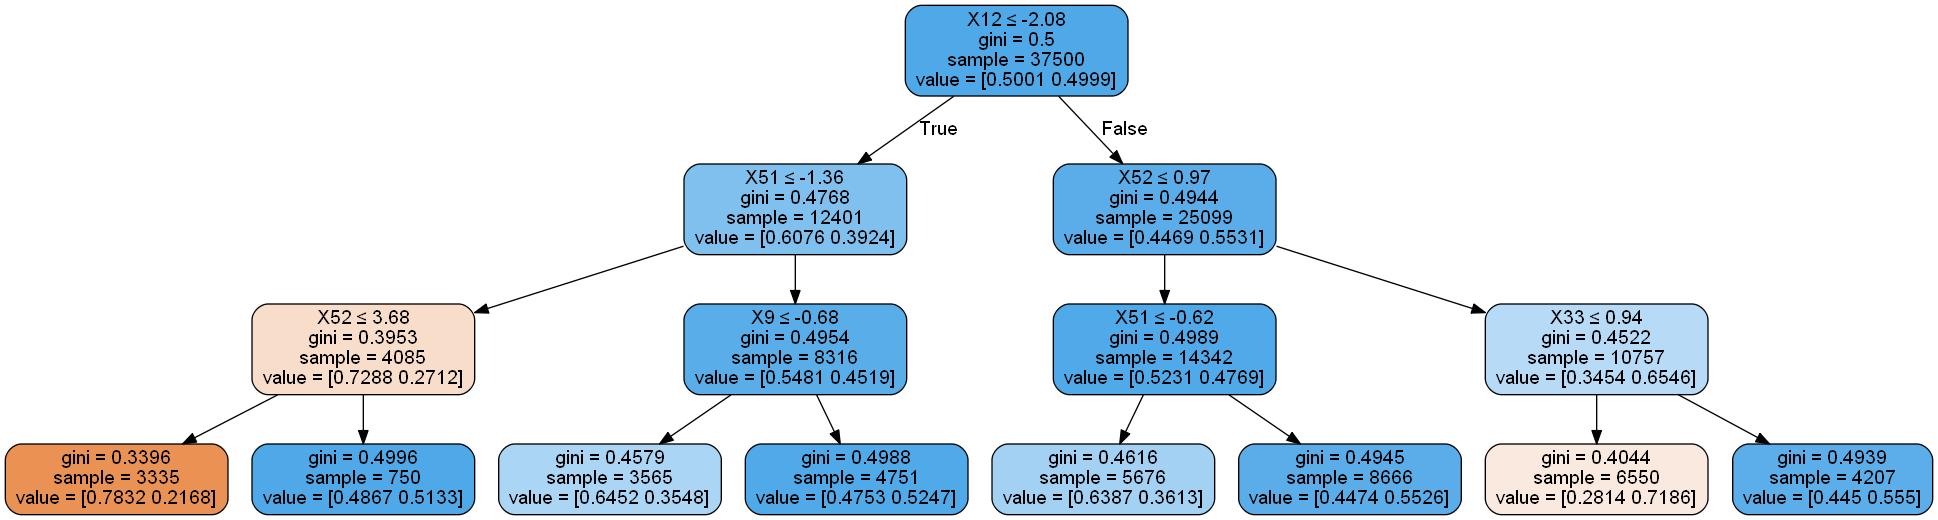

In [6]:
# score keys args in below function to select score in graph. default: pred score key
# color_score_key to change color key
Image(graph.create_png(features_name=feature_name, score_keys=['gini','sample', 'value'], color_score_key='gini'))

In [7]:
# defining custom score function

def custom_population_cal_field_fn(graph, y, **kwargs):
    return {'Total': y.shape[0], 'Good': np.sum(y), 'Bad': np.sum(y==0)}


def custom_fit_score_fn(graph, node, y, population_cal_field, score_dict, **kwargs):
    pop = np.round(100*y.shape[0]/population_cal_field['Total'], 2)
    return {'PopulationFraction': f'{pop} %', 'Pr_Good': np.mean(y)}

def custom_compare_score_fn(graph, node, y, population_cal_field, score_dict,
                             fit_population_cal_field, fit_score_dict, **kwargs):
    pred_score_key = graph.score_data['pred_score_key']
    Pr_Good_train = dict_utils.get(fit_score_dict[node], pred_score_key, np.nan)
    Pr_Good_test = np.mean(y)
    return {'Pr_Good_train': Pr_Good_train,
            'Pr_Good_test': Pr_Good_test, 
            'error': Pr_Good_train - Pr_Good_test}

custom_fit_score_handler = ScoreHandler('Pr_Good', 'Pr_Good', 'population_cal_field',
                                          custom_population_cal_field_fn, custom_fit_score_fn)

custom_compare_score_handler = ScoreHandler('Pr_Good_train', 'error', 'train_population_cal_field',
                                              custom_population_cal_field_fn, custom_compare_score_fn)

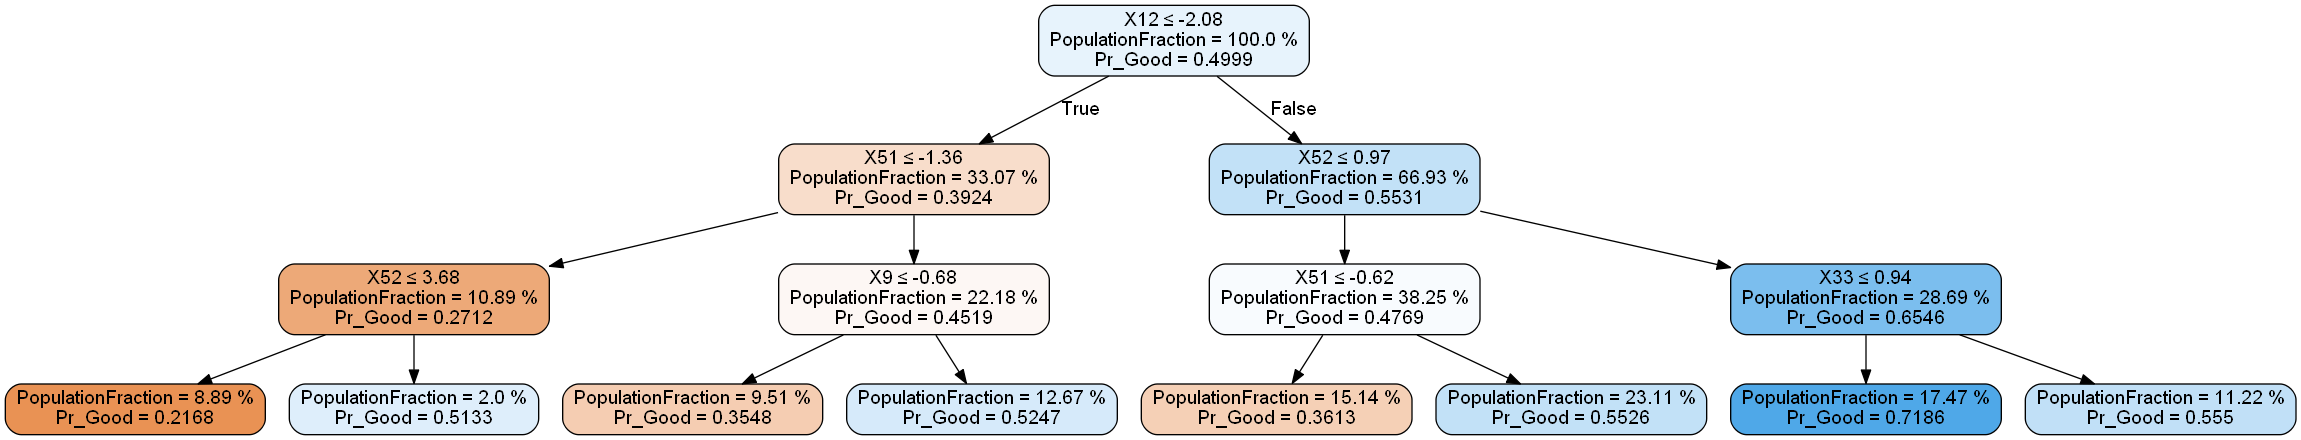

In [8]:
# fitting graph to evaluate custom score
graph = graph.fit(X_train, y_train, score_handler=custom_fit_score_handler)

# score keys args in below function to select score in graph. default: pred score key
Image(graph.create_png(features_name=feature_name, score_keys=['PopulationFraction', 'Pr_Good'])) 

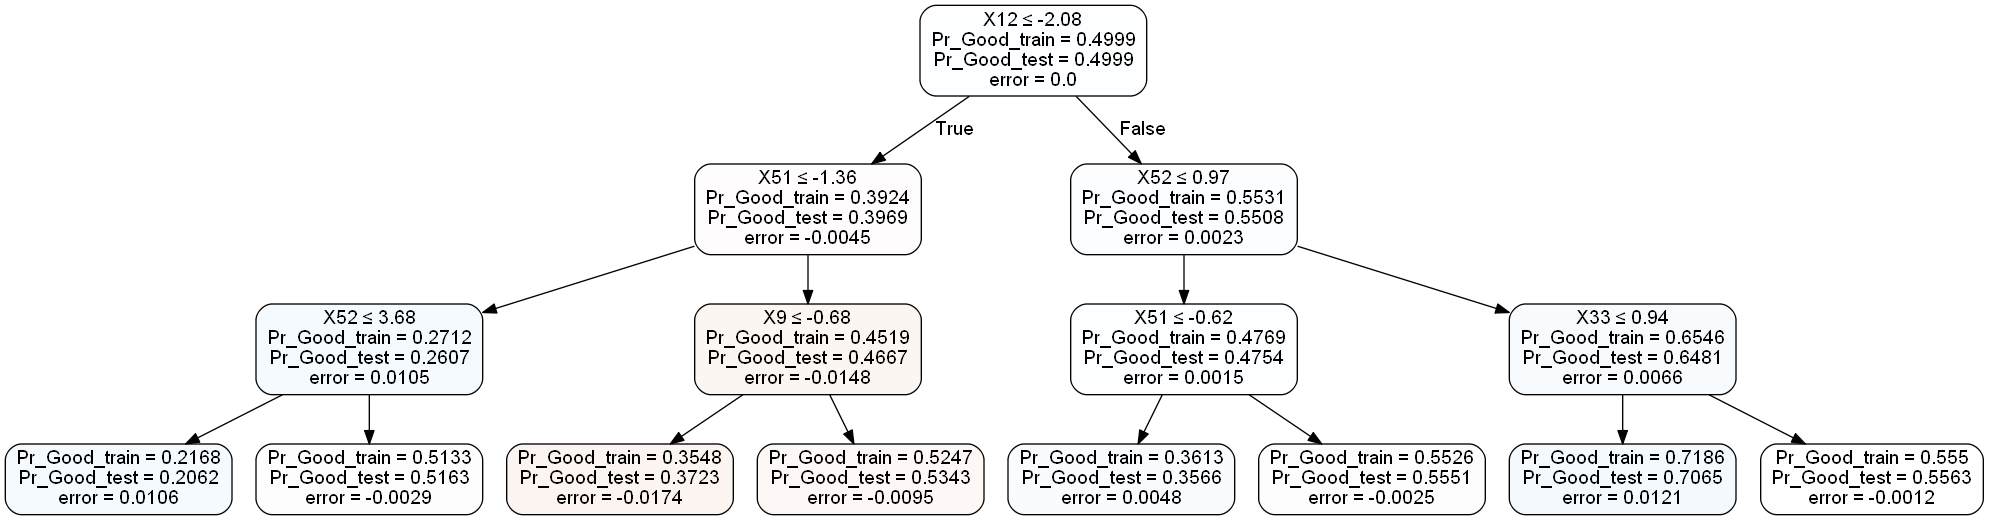

In [9]:
# comparing train and test score
graph = graph.compare_fit(X_test, y_test, score_handler=custom_compare_score_handler)

# normalize_bound arg in below function to provide color normalize range. default: min and max score
Image(graph.create_png(features_name=feature_name, score_keys=['Pr_Good_train', 'Pr_Good_test', 'error'], normalize_bound=[-0.2, 0.2]))